<a href="https://colab.research.google.com/github/vyankateshgithubber/Audio-Source-Count-Estimation/blob/working/source_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
!pip install wavefile
import wavefile
import wave, os, glob

In [40]:
def stft(y,sr):
  S = np.abs(librosa.stft(y[:80000],n_fft=512,hop_length=256))
  return S

path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_165/'
k1 = 0.4
k2 = 0.4
audiofilepath = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
sr,signal = wavefile.load(audiofilepath)
signal=np.reshape(signal,signal.size)
stft(signal,sr)

array([[6.63296203e-04, 1.85080711e-03, 3.12529248e-03, ...,
        1.83428880e-02, 1.44593557e-02, 2.89712697e-02],
       [6.52960734e-04, 4.16147988e-03, 8.00371077e-03, ...,
        9.45738927e-02, 1.78474579e-02, 9.47335139e-02],
       [1.20965473e-03, 3.66171985e-03, 8.63200519e-03, ...,
        4.56406958e-02, 1.15683146e-01, 1.93280473e-01],
       ...,
       [4.60684959e-07, 8.82675479e-08, 4.25199289e-08, ...,
        1.36309541e-06, 1.56973920e-06, 6.52115676e-04],
       [5.48034791e-07, 1.17905458e-07, 1.42095857e-07, ...,
        2.94837582e-06, 8.30223144e-07, 6.52303745e-04],
       [6.03361173e-07, 1.82623026e-07, 3.21631347e-07, ...,
        2.77220374e-06, 2.00435397e-06, 6.49940455e-04]], dtype=float32)

In [41]:
def features_labels():
  X = []
  y = []
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_165/'

  for k1 in np.arange(0.02,1.02,0.02):
    for k2 in np.arange(0.02,1.02,0.02):
      audiofilepath = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
      #sr,signal = wavefile.load(audiofilepath)
      #signal=np.reshape(signal,signal.size)
      signal, sr = librosa.load(audiofilepath,sr=16000,offset=0,duration=5)
      X.append(stft(signal,sr))
      #y.append(1)
      y.append(2)

  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
    #sr,signal = wavefile.load(audiofilepath)
    #signal=np.reshape(signal,signal.size)
    signal, sr = librosa.load(audiofilepath,sr=16000,offset=0,duration=5)
    X.append(stft(signal,sr))
    #y.append(0)
    y.append(1)


  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path +'1_'+str(round(0,3))+'_'+str(round(k1,3))+'.wav'
    #sr,signal = wavefile.load(audiofilepath)
    #signal=np.reshape(signal,signal.size)
    signal, sr = librosa.load(audiofilepath,sr=16000,offset=0,duration=5)
    X.append(stft(signal,sr))
    #y.append(0)
    y.append(1)
  
  #add the code so as to take the audio file and append the x and y lablel for the 0 source,
  #source 0-0 , source 1-1 and source 2-2 (sources,labels)
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/0'
  #zeros=np.zeros((1,4999))
  for filename in glob.glob(os.path.join(path, '*.wav')):
    #sr,signal = wavefile.load(filename)
    #signal=np.append(signal,zeros)     #padding of zeros to make the size of audio file same from different dataset(added)
    #signal=np.reshape(signal,signal.size)
    signal, sr = librosa.load(audiofilepath,sr=16000,offset=0,duration=5)
    X.append(stft(signal,sr))
    y.append(0)


  X = np.array(X)
  y = np.array(y)
  size = X.shape
  X = X.reshape((size[0],size[1],size[2],1))
  y = y.reshape((size[0],1))
  return X,y

In [42]:
X,y = features_labels()
X.shape,y.shape

((5020, 257, 313, 1), (5020, 1))

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
print(X_train.shape,y_train.shape)

(4016, 257, 313, 1) (4016, 1)


In [44]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

def model1():
  input_shape = X_train.shape[1:]
  
  model = models.Sequential([
      layers.Input(shape=input_shape),
      preprocessing.Resizing(32, 32), 
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(3),#changed parameter from 1 to 3
    ])
  
  model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

  history = model.fit(X_train, y_train,validation_split=0.2, epochs=10)
  
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
  print("Test Loss ", test_loss)
  print("Test Accuracy ", test_acc)
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return model

Epoch 1/10
101/101 [==============================] - 13s 122ms/step - loss: 0.3765 - accuracy: 0.8309 - val_loss: 0.2262 - val_accuracy: 0.9092
Epoch 2/10
101/101 [==============================] - 13s 130ms/step - loss: 0.1999 - accuracy: 0.9153 - val_loss: 0.1253 - val_accuracy: 0.9664
Epoch 3/10
101/101 [==============================] - 13s 131ms/step - loss: 0.1574 - accuracy: 0.9421 - val_loss: 0.1443 - val_accuracy: 0.9565
Epoch 4/10
101/101 [==============================] - 13s 131ms/step - loss: 0.1404 - accuracy: 0.9446 - val_loss: 0.0899 - val_accuracy: 0.9701
Epoch 5/10
101/101 [==============================] - 13s 131ms/step - loss: 0.1083 - accuracy: 0.9580 - val_loss: 0.0773 - val_accuracy: 0.9801
Epoch 6/10
101/101 [==============================] - 13s 129ms/step - loss: 0.0897 - accuracy: 0.9695 - val_loss: 0.0687 - val_accuracy: 0.9801
Epoch 7/10
101/101 [==============================] - 13s 127ms/step - loss: 0.0965 - accuracy: 0.9670 - val_loss: 0.0721 - val_ac

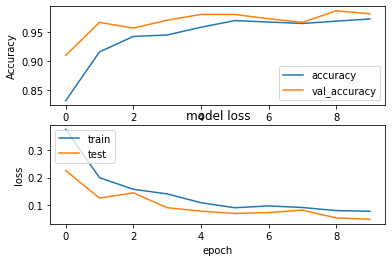

In [45]:
model = model1()

In [46]:
model.save('/content/drive/MyDrive/MajorProject/Models/my_model.h5')

In [47]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MajorProject/Models/my_model.h5')
# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                      

In [48]:
y_test_predict = new_model.predict(X_test)
y_pred = []
for y_p in y_test_predict:
  y_pred.append(np.argmax([y_p]))
y_pred = np.array(y_pred).reshape((len(y_pred),1))

In [49]:
def prediction(test_filepath,offset=0):
  #sr,signal = wavefile.load(test_filepath)
  #signal=np.reshape(signal,signal.size)
  signal, sr = librosa.load(test_filepath,sr=16000,duration=5,offset=offset) ## offset 
  feature = stft(signal,sr)
  size = feature.shape
  feature = feature.reshape(1,size[0],size[1])
  output = new_model.predict(feature)
  output = np.argmax(output)
  return output

In [66]:
path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_135/'
k1 = 0.2
k2 = 0.1
TwoSource = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
SingleSource = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
SingleSource='/content/drive/MyDrive/MajorProject/s1_female.wav'
NoSource='/content/drive/MyDrive/MajorProject/AudioDataset/0/0_0216c2.wav'
outputTwoSource = prediction(TwoSource)
outputNoSource = prediction(NoSource)
outputSingleSource = prediction(SingleSource)

test_filepath = "/content/2_bda997.wav"
output = prediction(test_filepath,0)
#output = []
#for i in range(4):
#  output.append(prediction(test_filepath,i))

In [67]:
outputTwoSource

2

In [68]:
import IPython.display as ipd
ipd.Audio(TwoSource) 

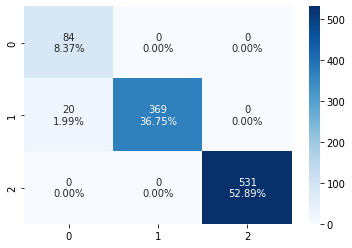

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test , y_pred)
#sns.heatmap(cf_matrix, annot=True)

#group_names = ["1","2","False Neg","True Pos"]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')